In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define paths to the datasets
npz_file_path_CNRS = r"D:\\Document\\Ressources Machine Learning\\Stage CROSSING\\autoencoder\\CNRS\\CNRS"
npz_file_path_SSM = r"D:\\Document\\Ressources Machine Learning\\Stage CROSSING\\autoencoder\\SSM"
npz_file_path_hEVA = r"D:\\Document\\Ressources Machine Learning\\Stage CROSSING\\autoencoder\\HumanEva"

path_output = r"D:\\Document\\Ressources Machine Learning\\Stage CROSSING\\autoencoder\\data"

npz_smplx = r"D:\\Document\\Ressources Machine Learning\\Stage CROSSING\\autoencoder\\smplx\\SMPLX_FEMALE.npz"
npz_file_smplx = np.load(npz_smplx, allow_pickle=True)

In [2]:
import torch

from models.body_model import BodyModel
from utils import rodrigues_2_rot_mat
from lbs import lbs, batch_rodrigues
import os

# Define the project root directory
# find the path to the project root directory
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
PROJECT_ROOT = os.path.join(PROJECT_ROOT, r'D:\\Document\\Ressources Machine Learning\\Stage CROSSING\\autoencoder')

# Define the path to SMPLX_MALE.npz using an absolute path
SMPLX_MODEL_MALE_PATH = os.path.join(PROJECT_ROOT, 'smplx', 'SMPLX_MALE.npz')

# The model from which will get the joints from
class SMPLX(BodyModel):
    def __init__(self, num_betas=16, **kwargs):
        super().__init__(bm_fname=SMPLX_MODEL_MALE_PATH, num_betas=num_betas, num_expressions=0, **kwargs)

    def forward(self, pose_body, betas, use_rodrigues=True):
        
        device = pose_body.device
        for name in ['init_pose_hand', 'init_pose_jaw','init_pose_eye', 'init_v_template', 'init_expression', 
                    'shapedirs', 'exprdirs', 'posedirs', 'J_regressor', 'kintree_table', 'weights', 'f']:
            _tensor = getattr(self, name)
            setattr(self, name, _tensor.to(device))

        batch_size = pose_body.shape[0]
        
        # The next line was added from the given notebook. It is in fact in the 
        # original BodyModel, but for some reason was not copied and led to errors.
        root_orient = self.init_root_orient.expand(batch_size, -1)
        pose_hand = self.init_pose_hand.expand(batch_size, -1)
        pose_jaw = self.init_pose_jaw.expand(batch_size, -1)
        pose_eye = self.init_pose_eye.expand(batch_size, -1)
        v_template = self.init_v_template.expand(batch_size, -1, -1)
        expression = self.init_expression.expand(batch_size, -1)

        init_pose = torch.cat([pose_jaw, pose_eye, pose_hand], dim=-1) # [B, 99] full of zeros
        if not use_rodrigues:
            init_pose = rodrigues_2_rot_mat(init_pose) # [B, 99] -> [B, 33, 3, 3]
        
        
        full_pose = torch.cat([root_orient, pose_body, init_pose], dim=-1) # No translation, concat of Pose body [B, 66] and init_pose [B, 99] = [B, 165]
        
        
        shape_components = torch.cat([betas, expression], dim=-1)
        shapedirs = torch.cat([self.shapedirs, self.exprdirs], dim=-1)
            
        verts, joints = lbs(betas=shape_components, pose=full_pose, v_template=v_template,
                        shapedirs=shapedirs, posedirs=self.posedirs, J_regressor=self.J_regressor,
                        parents=self.kintree_table[0].long(), lbs_weights=self.weights, pose2rot=use_rodrigues)
        
        faces = self.f.expand(batch_size, -1, -1)
        
        textures = torch.ones_like(verts)
        
        return dict(verts=verts, faces=faces, joints=joints)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
smplx = SMPLX().to(device)

In [41]:
def download_data(subject, path_dataset, path_output, title, time_length_per_sample):

    '''
    This function will take as a input a directory with .npz files, will retrive from them
    motionz of a body model represented as 24 joints over 50 time steps, and will save them
    as tensors.

    inputs :
        - subject : name of the subject's corresponding file.
        - path_dataset : path to the directory from which you'll want to download data.
        - path_output : path to the directory where you'll want to save the modified data.
        - title : what you'll want to see first in the files name.
        - time_length_per_sample : the time_length of samples you'll want to save.
    '''

    path = os.path.join(path_dataset, str(subject))
    for filename in os.listdir(path):
        
        # the dataset that'll be saved
        dataset = []

        file_path = os.path.join(path, filename)
        npz_file = np.load(file_path, allow_pickle=True)

        # Extract the data
        data = {}
        for key in npz_file.keys():
            data[key] = npz_file[key]

        pose_body = torch.tensor(data['pose_body'], dtype=torch.float32).to(device) # 21 joints (63 vec)
        beta = torch.tensor(data['betas'], dtype=torch.float32).unsqueeze(0).repeat(len(pose_body), 1).to(device)
        target = smplx(pose_body=pose_body, betas=beta, use_rodrigues=True)
        joints = target['joints']
        
        # Cut the time sequence into multiple samples of time_length_per_sample size
        time_length = joints.shape[0]
        nb_sample = time_length // time_length_per_sample
        for i in range(nb_sample):
            dataset.append(joints[i:time_length_per_sample+i, :24])

        # Save the dataset
        dataset = torch.stack(dataset)
        torch.save(dataset, os.path.join(path_output, f'{title}_{subject}_{filename}.pt'))

In [46]:
download_data(subject='20160330_03333',
              path_dataset=npz_file_path_SSM,
              path_output=path_output,
              title='SSM',
              time_length_per_sample=50)

In [47]:
# Check the shape of all downloaded data until now

dataset = []
for filename in os.listdir(path_output):
    file_path = os.path.join(path_output, filename)
    loaded_tensor = torch.load(file_path)
    dataset.append(loaded_tensor)

dataset = torch.cat(dataset)
print(dataset.shape)

C:\Users\jeanv\AppData\Local\Temp\ipykernel_14672\4131104800.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_tensor = torch.load(file_path)


torch.Size([165, 50, 24, 3])


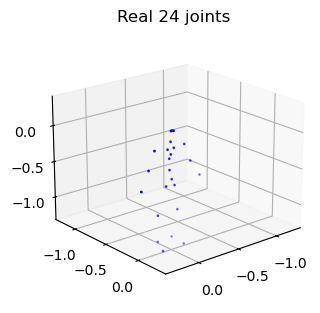

In [49]:
# Print an example

real_joints24 = dataset[0,0]

fig = plt.figure(figsize=(12, 6))
ax3 = fig.add_subplot(133, projection='3d')


ax3.scatter(real_joints24[:,0], real_joints24[:,2], real_joints24[:,1], c='b', marker='o', s=1)
ax3.set_title("Real 24 joints")
val_min = real_joints24.min()
val_max = real_joints24.max()
ax3.set_xlim(val_min, val_max)
ax3.set_ylim(val_min, val_max)
ax3.set_zlim(val_min, val_max)
ax3.view_init(elev=20, azim=50)